# Introduction

In this notebook, we will be working on identifying and tracking a shock.


In [ ]:
import sys, os
davinci_dir = r"C:\daVinci"
sys.path.append(davinci_dir)
from daVinci import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# The Case

For this case, we will be using an extended version of the shock tunnel tutorial OpenFOAM v12 has. The shock will reflect off the RHS wall and travel, cross the expansion wave, and then reflect off the LHS wall.

So first, we can pull and store the data.


In [2]:
working_dir = r"N:\detFOAM\cases\shockTube_reflection\VTK"
os.chdir( working_dir )

data_file = "shockTube_reflection_*"


In [3]:
N_pts = 10000
rake_shock = rake( ( np.linspace( -5 , 5 , num=N_pts ) , np.zeros( N_pts ) , np.zeros( N_pts ) ) , data_file , file_format="vtk" )


File list:	['shockTube_reflection_0.vtk', 'shockTube_reflection_20.vtk', 'shockTube_reflection_40.vtk', 'shockTube_reflection_60.vtk', 'shockTube_reflection_80.vtk', 'shockTube_reflection_100.vtk', 'shockTube_reflection_120.vtk', 'shockTube_reflection_140.vtk', 'shockTube_reflection_160.vtk', 'shockTube_reflection_180.vtk', 'shockTube_reflection_200.vtk', 'shockTube_reflection_220.vtk', 'shockTube_reflection_240.vtk', 'shockTube_reflection_260.vtk', 'shockTube_reflection_280.vtk', 'shockTube_reflection_300.vtk', 'shockTube_reflection_320.vtk', 'shockTube_reflection_340.vtk', 'shockTube_reflection_360.vtk', 'shockTube_reflection_380.vtk', 'shockTube_reflection_400.vtk', 'shockTube_reflection_420.vtk', 'shockTube_reflection_440.vtk', 'shockTube_reflection_460.vtk', 'shockTube_reflection_480.vtk', 'shockTube_reflection_500.vtk', 'shockTube_reflection_520.vtk', 'shockTube_reflection_540.vtk', 'shockTube_reflection_560.vtk', 'shockTube_reflection_580.vtk', 'shockTube_reflection_600.vtk', 's

In [4]:
rake_shock.paraviewDataRead( working_dir )


Time steps available: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 15

In [5]:
rake_shock.timeOverride( 1e-4 * np.array( rake_shock.time_steps ) )


In [6]:
rake_shock.hdf5Write( "rake_shock" , working_dir )


# Data

With all that stored, let's look at the data using the x-Velocity

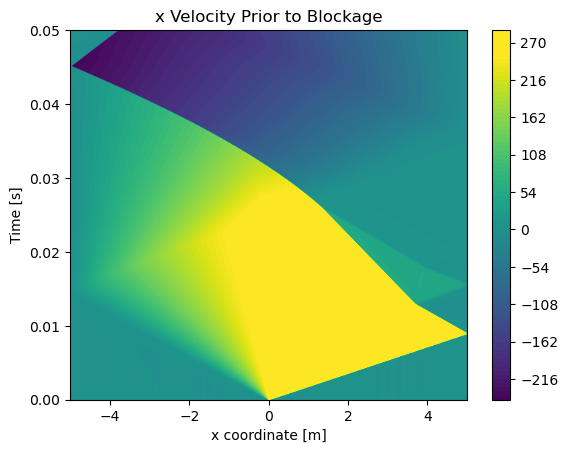

In [7]:
X = rake_shock.points[:,0]
Y = rake_shock.time_steps
C = rake_shock.data["U:X"]

plt.contourf( X , Y , C , 100 , vmin=-250 , vmax=250 )
plt.colorbar()
plt.title("x Velocity Prior to Blockage")
plt.xlabel("x coordinate [m]")
plt.ylabel("Time [s]")
plt.show()


So, obviously, there are discontinuities and otherwise that can be tracked via edge finding algorithms.


# The Wavelet Transform

For our purposes, we can look at the Discrete Wavelet Transform (DWT) of our data, with is a function of t and x, ie: $u(t,\mathbf{x})$


In [8]:
shock_wavelet = WaveletData( rake_shock.data , layer_header="p" , N_dims=2 )


In [9]:
shock_wavelet.waveletTransform( ["bior1.3","bior1.5","bior3.3","bior3.5"], keys=["p","T","U:X"] )


So now we can look at the data that we have retrieved. The biorthogonal wavelet families should be the shapes that best represent the discontinuity of the shock, thus their selection.


In [10]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']


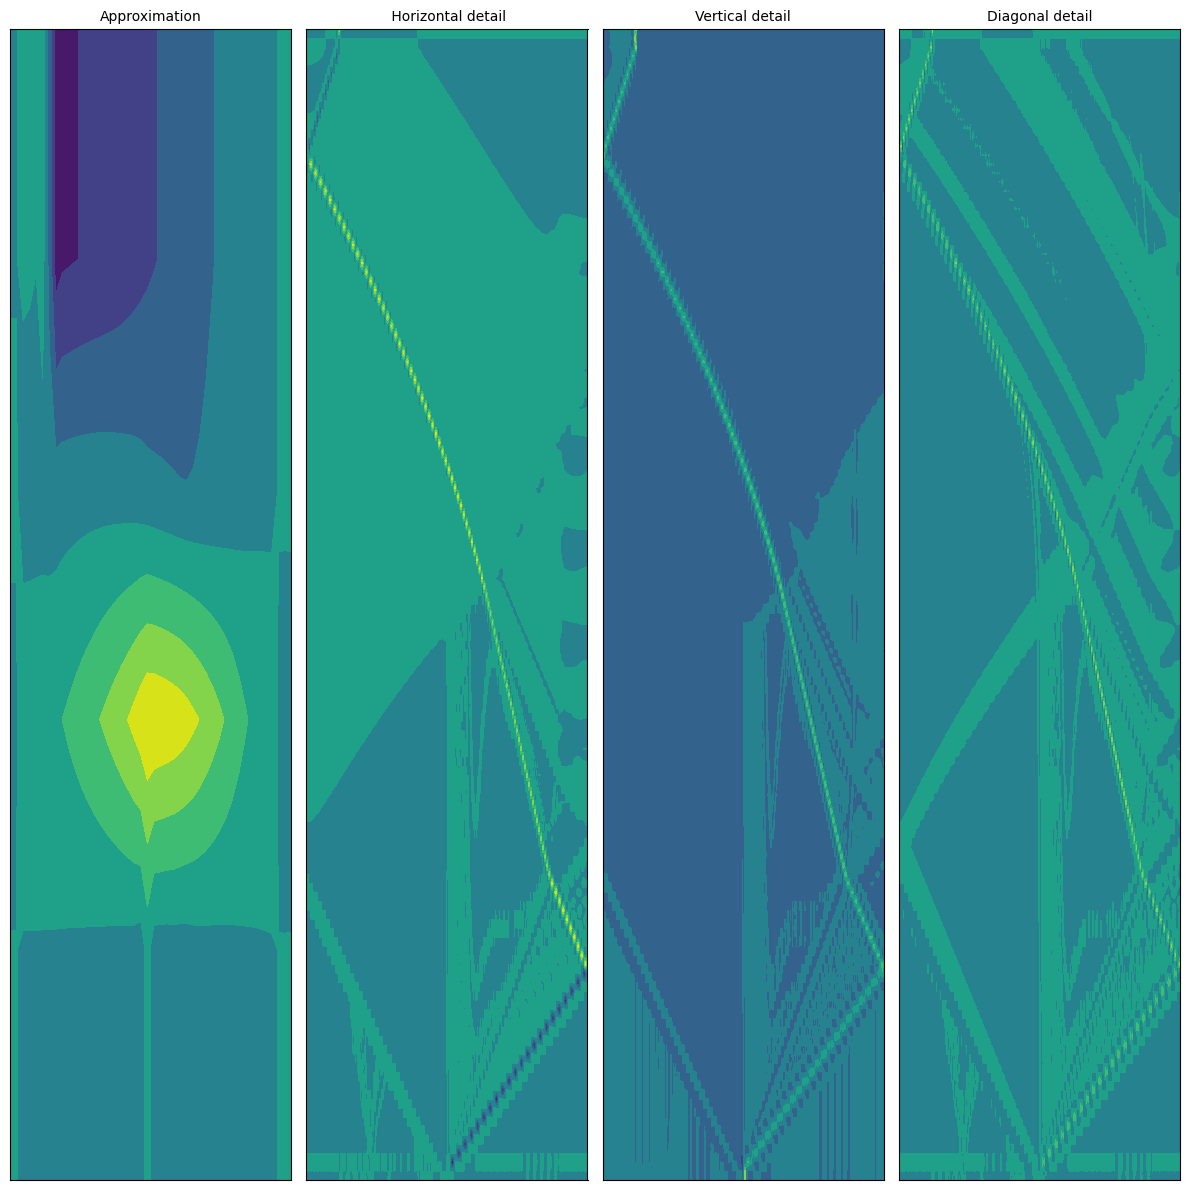

In [11]:
LL = shock_wavelet.coeffs["bior1.3"]["U:X"][0]
(LH, HL, HH) = shock_wavelet.coeffs["bior1.3"]["U:X"][-2]


fig = plt.figure(figsize=(12, 12))

for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    x = rake_shock.points[:np.shape(a)[-1],0]
    y = rake_shock.time_steps[:np.shape(a)[0]]
    c = a
    ax.contourf( x, y, c )
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


For the lowest order Biorthogonal wavelet, there is a clear shock trend that presents itself. It is interesting that the values for the DWT are the opposite sign of the 

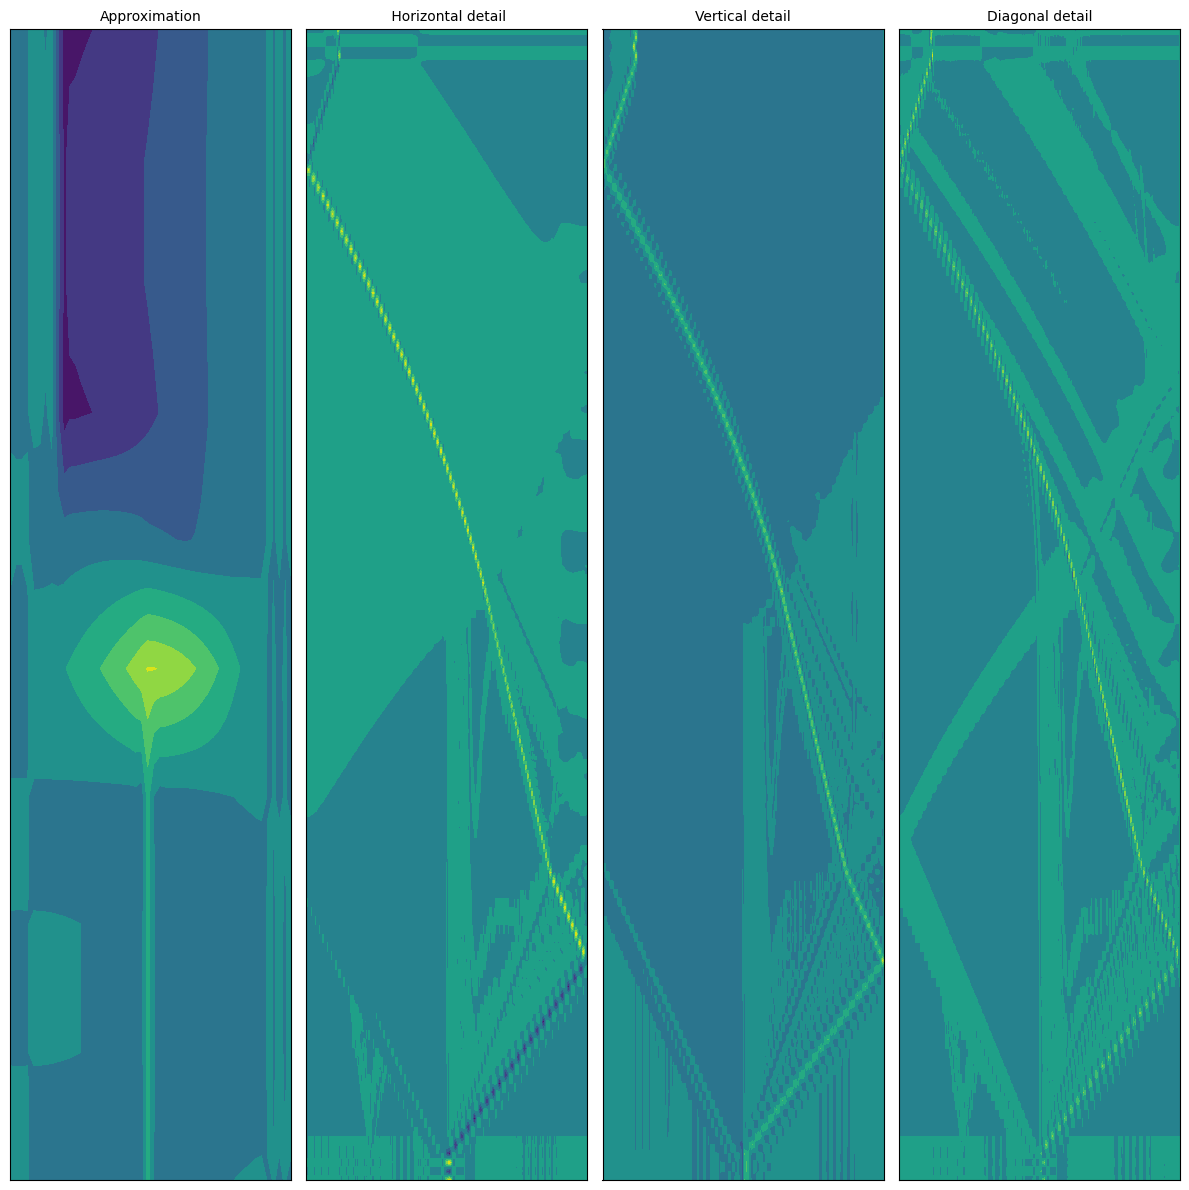

In [12]:
LL = shock_wavelet.coeffs["bior1.5"]["U:X"][0]
(LH, HL, HH) = shock_wavelet.coeffs["bior1.5"]["U:X"][-2]


fig = plt.figure(figsize=(12, 12))

for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    x = rake_shock.points[:np.shape(a)[-1],0]
    y = rake_shock.time_steps[:np.shape(a)[0]]
    c = a
    ax.contourf( x, y, c )
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


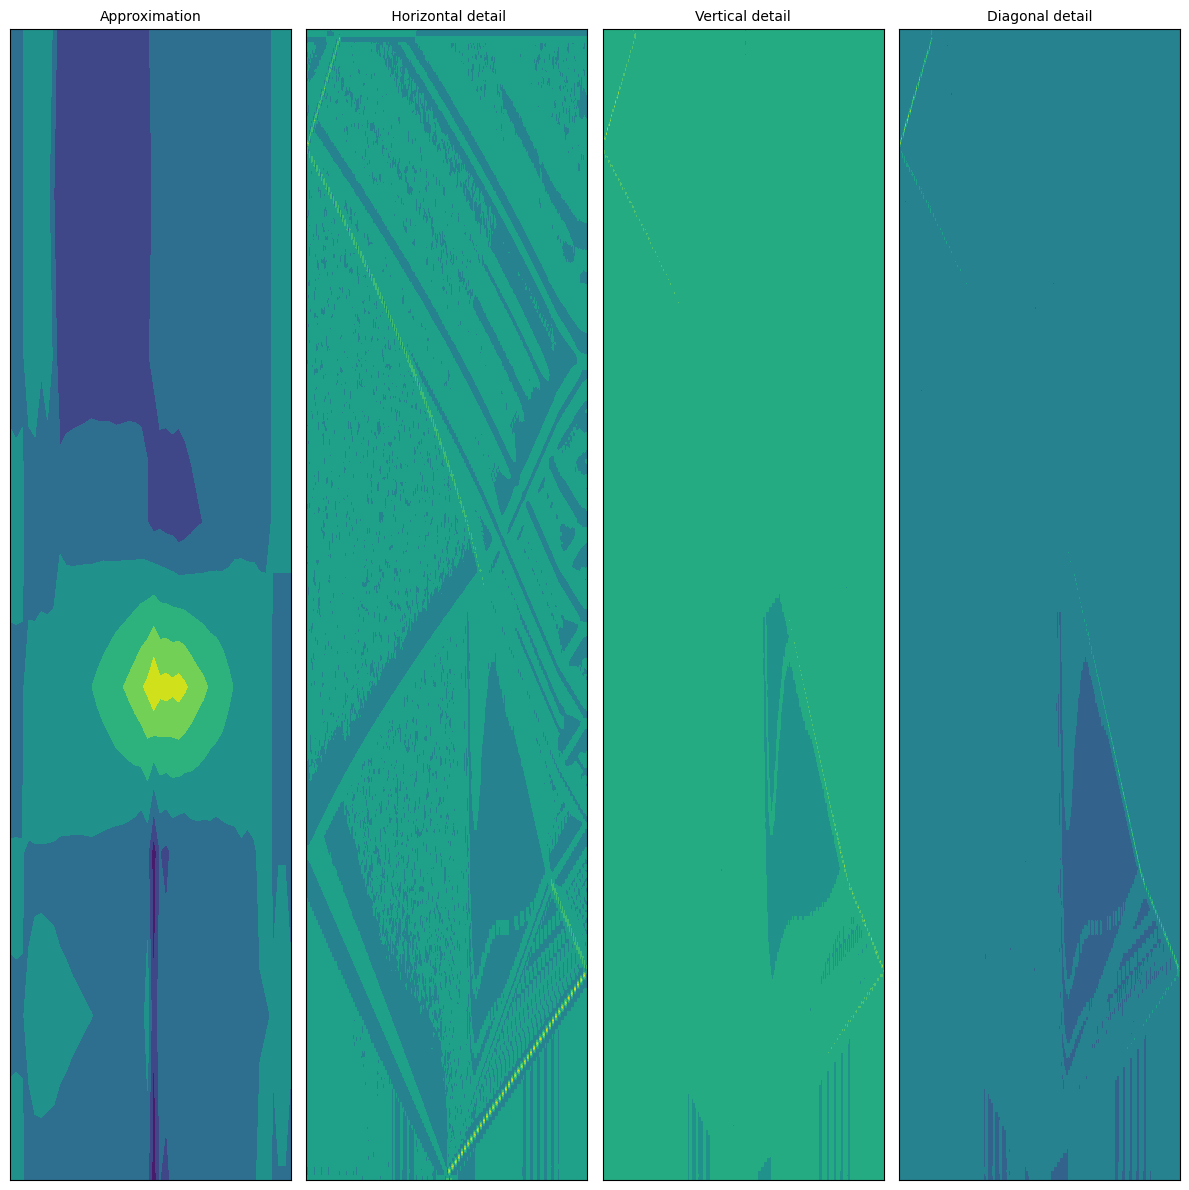

In [13]:
LL = shock_wavelet.coeffs["bior3.3"]["U:X"][0]
(LH, HL, HH) = shock_wavelet.coeffs["bior3.3"]["U:X"][-1]


fig = plt.figure(figsize=(12, 12))

for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    x = rake_shock.points[:np.shape(a)[-1],0]
    y = rake_shock.time_steps[:np.shape(a)[0]]
    c = a
    ax.contourf( x, y, c )
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



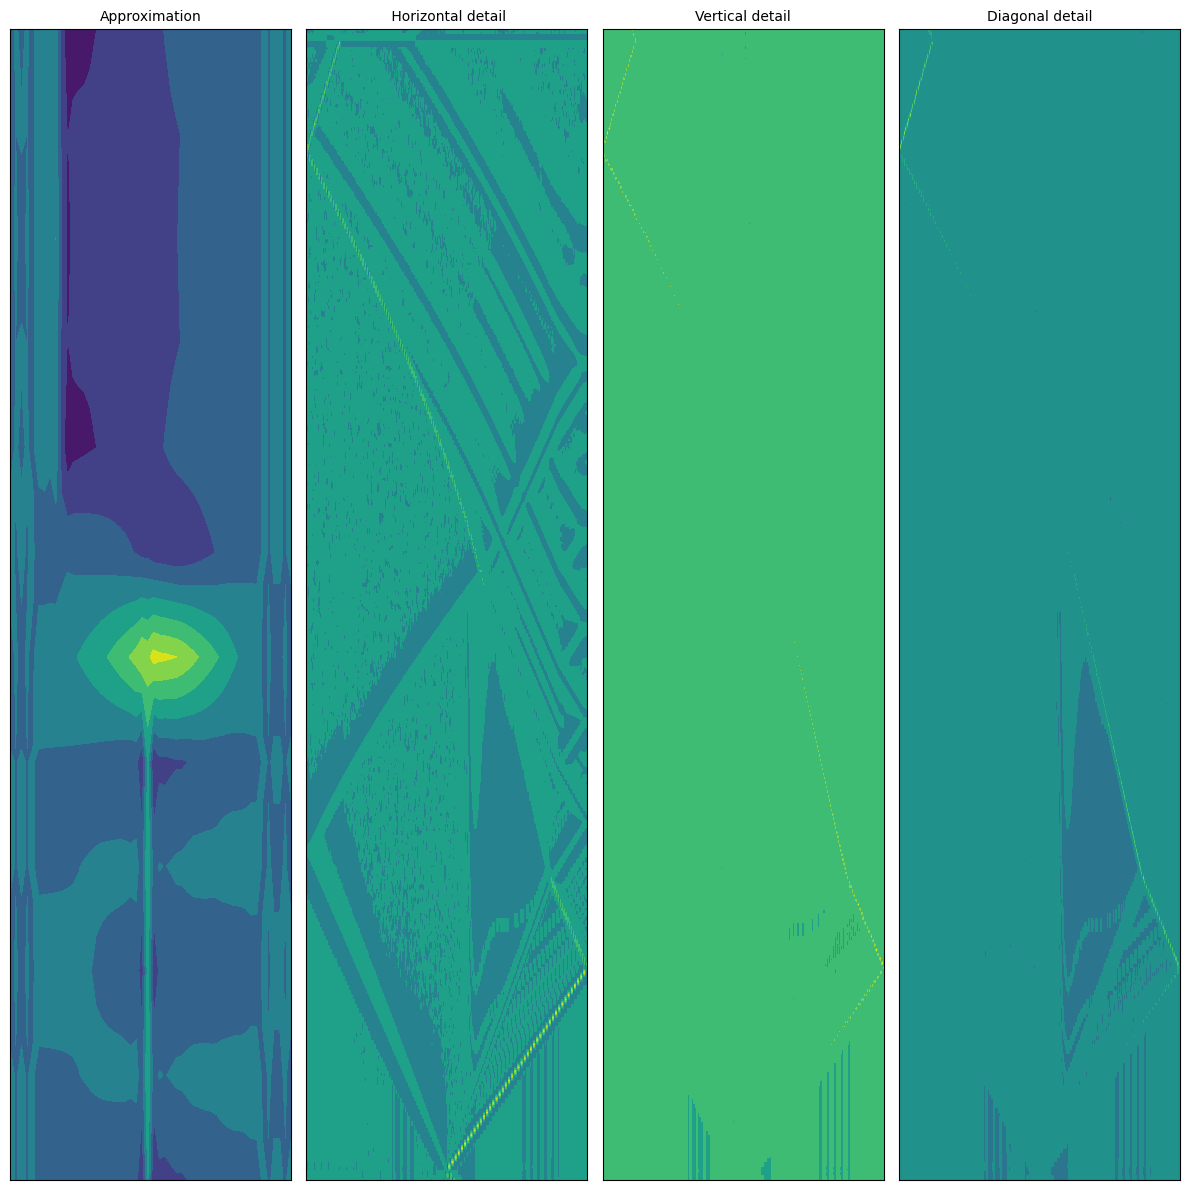

In [14]:
LL = shock_wavelet.coeffs["bior3.5"]["U:X"][0]
(LH, HL, HH) = shock_wavelet.coeffs["bior3.5"]["U:X"][-1]


fig = plt.figure(figsize=(12, 12))

for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    x = rake_shock.points[:np.shape(a)[-1],0]
    y = rake_shock.time_steps[:np.shape(a)[0]]
    c = a
    ax.contourf( x, y, c )
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



With all this data, we can detect where the peak response of the detail wavelets, which will be the shock location.


In [15]:
comp_rake = compressibleGas()
rake_shock.data["shock_location"], rake_shock.data["shock_velocity"] = comp_rake.shockTracking( rake_shock.data , [rake_shock.points[:,0]] , rake_shock.time_steps )


In [16]:
t_pred = np.linspace( 0 , 0.01 , num=1000)
x_pred = 558 * t_pred


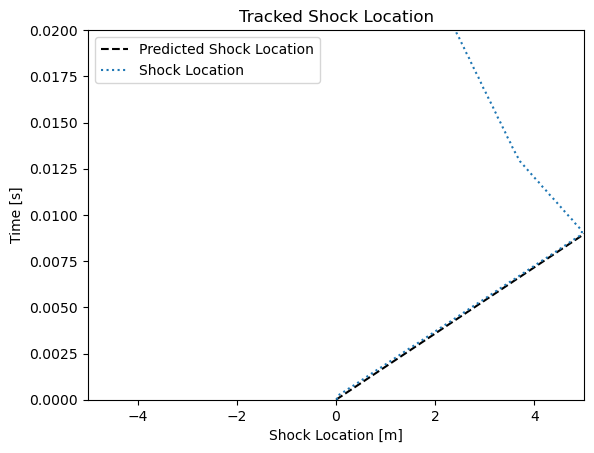

In [17]:
plt.plot( x_pred , t_pred , '--k' , label="Predicted Shock Location" )
plt.plot( rake_shock.data["shock_location"][0] , comp_rake.t_pts , ':' , label="Shock Location" )


plt.title("Tracked Shock Location")
plt.ylabel("Time [s]")
plt.xlabel("Shock Location [m]")
plt.xlim((-5,5))
plt.ylim((0,20e-3))
plt.legend(loc="best")
plt.show()


In [18]:
rake_shock.data["shock_velocity"]


array([-3.02339532e+02,  3.02339532e+02,  5.79484103e+02,  5.74445111e+02,
        5.79484103e+02,  5.59328134e+02,  5.54289142e+02,  5.54289142e+02,
        5.74445111e+02,  5.74445111e+02,  5.54289142e+02,  5.59328134e+02,
        5.59328134e+02,  5.54289142e+02,  5.74445111e+02,  5.74445111e+02,
        5.54289142e+02,  5.59328134e+02,  5.59328134e+02,  5.54289142e+02,
        5.74445111e+02,  5.74445111e+02,  5.54289142e+02,  5.59328134e+02,
        5.59328134e+02,  5.54289142e+02,  5.74445111e+02,  5.74445111e+02,
        5.54289142e+02,  5.59328134e+02,  5.59328134e+02,  5.54289142e+02,
        5.74445111e+02,  5.74445111e+02,  5.54289142e+02,  5.54289142e+02,
        5.59328134e+02,  5.59328134e+02,  5.74445111e+02,  5.74445111e+02,
        5.54289142e+02,  5.54289142e+02,  5.59328134e+02,  5.59328134e+02,
        5.74445111e+02,  3.27534493e+02, -1.25974805e+02, -3.32573485e+02,
       -3.27534493e+02, -3.27534493e+02, -3.47690462e+02, -3.27534493e+02,
       -3.27534493e+02, -